# Combined CDOM and SST Analysis

This notebook demonstrates an end-to-end pipeline for processing satellite L2 RRS data to derive CDOM (Colored Dissolved Organic Matter) and MODIS L2P data for SST (Sea Surface Temperature). It then visualizes the SST, where the visibility (alpha/opacity) of the SST data is controlled by the concentration of CDOM. Higher CDOM concentrations will result in more visible SST. CDOM contours will also be overlaid.

**Pipeline Steps:**

1.  **Import libraries** and set up the environment.
2.  **Define constants and parameters** for CDOM calculation, SST processing, shared geographical bounding box, and binning.
3.  **CDOM Processing:**
    *   Search for and load L2 RRS NetCDF files.
    *   Inspect RRS data.
    *   Extract RRS data (GPU accelerated).
    *   Calculate CDOM.
    *   Clip, bin, and interpolate CDOM data.
4.  **SST Processing:**
    *   Search for and load MODIS L2P SST NetCDF files.
    *   Inspect SST data.
    *   Extract SST data (GPU accelerated).
    *   Clip, bin, convert to Celsius, apply thresholds, and interpolate SST data to the same grid as CDOM.
5.  **Combined Plotting:**
    *   Plot SST, using its value for color.
    *   Modulate the opacity of the SST plot based on CDOM concentration.
    *   Overlay CDOM concentration contours.
    *   Include colorbars/legends for clarity.
6.  **(Optional) Plot individual raw CDOM and SST maps** for reference.

### Library Imports

Import essential libraries for file handling, numerical operations, plotting, and custom processing.

In [1]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
import xarray as xr # For inspecting NetCDF variables
import matplotlib.colors

import sys
sys.dont_write_bytecode = True

# Import custom pipeline components
import importlib
import l2_pipeline # Import the module itself to reload
importlib.reload(l2_pipeline)
from l2_pipeline import L2DatasetLoader, GPUDataExtractor, SelectiveInterpolator

# Suppress RuntimeWarnings that can occur with NaNs in calculations
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib') # Ignore Matplotlib UserWarnings for set_bad

### Define Constants and Parameters

Define constants for CDOM calculation, SST processing, geographical area, binning, and data paths.

In [2]:
# --- Shared Geographical and Binning Parameters ---
# For combined analysis, a common bounding box is essential.
# Let's use a region that typically has both signals, e.g., Texas-Louisiana Shelf.
lon_min, lon_max = -95.0, -88.0 # Adjusted for potential overlap
lat_min, lat_max = 27.5, 30.5

lat_bins = 200 # Number of latitude bins (height)
lon_bins = 300 # Number of longitude bins (width)

# --- CDOM Calculation Constants ---
B0 = 0.2487
B1 = 14.028
B2 = 4.085

# --- L2 RRS Data Configuration (for CDOM) ---
data_dir_l2_rrs = r"E:\satdata\Texas Louisiana Shelf_2024-06-01_2024-06-30" # UPDATE THIS PATH
rrs_vars_list = ['Rrs_412', 'Rrs_555']
rrs_data_group = 'geophysical_data'
interpolation_threshold_cdom = 32

# --- MODIS L2P Data Configuration (for SST) ---
data_dir_sst = r"E:\satdata\MODIS_A-JPL-L2P-v2019.0_Texas Louisiana Shelf_2024-06-01_2024-06-30" # UPDATE THIS PATH
sst_variable_to_plot = 'sea_surface_temperature'
# For MODIS L2P, lat and lon are often 2D data variables.
sst_variables_to_load = [sst_variable_to_plot, 'lat', 'lon']
sst_data_group = None # Variables typically in root for MODIS L2P
min_sst_celsius_threshold = -2.0 # More realistic threshold for SST after Celsius conversion
interpolation_threshold_sst = 32

print(f"Region: Lon ({lon_min}, {lon_max}), Lat ({lat_min}, {lat_max})")
print(f"Grid: {lat_bins} lat bins, {lon_bins} lon bins")

Region: Lon (-95.0, -88.0), Lat (27.5, 30.5)
Grid: 200 lat bins, 300 lon bins


## CDOM Data Processing

### Searching for L2 RRS Data Files (CDOM)

In [3]:
nc_files_rrs = glob.glob(os.path.join(data_dir_l2_rrs, '**', '*.nc'), recursive=True)
if not nc_files_rrs:
    print(f"Warning: No .nc files found for L2 RRS in {data_dir_l2_rrs}.")
else:
    print(f"Found {len(nc_files_rrs)} L2 RRS files for CDOM processing.")
# nc_files_rrs = nc_files_rrs[:5] # Limiting for quick test
# print(f"Using {len(nc_files_rrs)} L2 RRS files.")

Found 42 L2 RRS files for CDOM processing.


### Inspecting Variables in L2 RRS Data (CDOM)

In [4]:
if nc_files_rrs:
    print(f"Inspecting variables in the first L2 RRS file: {nc_files_rrs[0]}")
    try:
        with xr.open_dataset(nc_files_rrs[0], group=rrs_data_group) as ds_geo:
            print(f"\nVariables in group: '{rrs_data_group}'")
            for var_name_ds in ds_geo.variables: print(f"  {var_name_ds}")
        with xr.open_dataset(nc_files_rrs[0], group='navigation_data') as ds_nav:
            print(f"\nVariables in group: 'navigation_data'")
            for var_name_ds in ds_nav.variables: print(f"  {var_name_ds}")
    except Exception as e:
        print(f"Error inspecting RRS file (or a group): {e}")
else:
    print("No L2 RRS NetCDF files found to inspect for CDOM.")

Inspecting variables in the first L2 RRS file: E:\satdata\Texas Louisiana Shelf_2024-06-01_2024-06-30\AQUA_MODIS.20240601T191500.L2.OC.nc

Variables in group: 'geophysical_data'
  aot_869
  angstrom
  Rrs_412
  Rrs_443
  Rrs_469
  Rrs_488
  Rrs_531
  Rrs_547
  Rrs_555
  Rrs_645
  Rrs_667
  Rrs_678
  chlor_a
  Kd_490
  pic
  poc
  ipar
  nflh
  par
  l2_flags

Variables in group: 'navigation_data'
  longitude
  latitude
  tilt


### Loading L2 RRS Datasets (CDOM)

In [5]:
datasets_rrs = []
if nc_files_rrs:
    try:
        loader_rrs = L2DatasetLoader(variables=rrs_vars_list, group=rrs_data_group)
        datasets_rrs = loader_rrs.load_multiple(nc_files_rrs)
        print(f"Successfully loaded {len(datasets_rrs)} L2 RRS datasets for CDOM.")
    except Exception as e:
        print(f"Error loading L2 RRS datasets: {e}")
else:
    print("No L2 RRS files found to load for CDOM.")

Successfully loaded 42 L2 RRS datasets for CDOM.


### GPU Data Extraction for L2 RRS (CDOM)

In [6]:
lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = np.array([]), np.array([]), {var: np.array([]) for var in rrs_vars_list}
if datasets_rrs:
    try:
        extractor_rrs = GPUDataExtractor(variables=rrs_vars_list)
        lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = extractor_rrs.extract(datasets_rrs)
        print(f"L2 RRS data extraction for CDOM complete. Extracted {len(lon_rrs_flat)} data points.")
    except Exception as e:
        print(f"Error during L2 RRS data extraction: {e}")
else:
    print("No L2 RRS datasets loaded, skipping L2 RRS data extraction for CDOM.")

L2 RRS data extraction for CDOM complete. Extracted 12725916 data points.


### CDOM Calculation

In [7]:
cdom_values = np.array([])
final_lon_cdom, final_lat_cdom, final_cdom_raw = np.array([]), np.array([]), np.array([])

if lon_rrs_flat.size > 0 and rrs_vars_data_flat:
    Rss412 = rrs_vars_data_flat.get(rrs_vars_list[0], np.array([]))
    Rss555 = rrs_vars_data_flat.get(rrs_vars_list[1], np.array([]))
    
    if Rss412.size > 0 and Rss555.size > 0 and Rss412.shape == lon_rrs_flat.shape and Rss555.shape == lon_rrs_flat.shape:
        term_ratio = Rss412 / Rss555
        term_numerator = term_ratio - B0
        term_division = term_numerator / B2
        valid_log_mask = term_division > 0
        
        cdom_values_temp = np.full_like(term_division, np.nan)
        if np.any(valid_log_mask):
            cdom_values_temp[valid_log_mask] = (np.log(term_division[valid_log_mask])) / (-B1)
        
        cdom_values = cdom_values_temp
        print(f"CDOM calculation complete. Min: {np.nanmin(cdom_values):.4f}, Max: {np.nanmax(cdom_values):.4f}")

        valid_mask = ~np.isnan(lon_rrs_flat) & ~np.isnan(lat_rrs_flat) & ~np.isnan(cdom_values)
        final_lon_cdom = lon_rrs_flat[valid_mask]
        final_lat_cdom = lat_rrs_flat[valid_mask]
        final_cdom_raw = cdom_values[valid_mask]
        print(f"Filtered NaNs for CDOM data, {len(final_lon_cdom)} valid data points remaining.")
    else:
        print("Skipping CDOM calculation: Rrs_412 or Rrs_555 data not available, empty, or shape mismatch.")
else:
    print("Skipping CDOM data processing: No L2 RRS data extracted.")

CDOM calculation complete. Min: -inf, Max: 1.0487
Filtered NaNs for CDOM data, 12472520 valid data points remaining.


### Clipping, Binning, and Interpolating CDOM Data

In [8]:
binned_cdom_interpolated = np.array([[]])
lat_edges_grid, lon_edges_grid = None, None # To store grid edges for both CDOM and SST

if final_lon_cdom.size > 0:
    clip_mask_cdom = (
        (final_lon_cdom >= lon_min) & (final_lon_cdom <= lon_max) &
        (final_lat_cdom >= lat_min) & (final_lat_cdom <= lat_max)
    )
    clipped_lon_cdom = final_lon_cdom[clip_mask_cdom]
    clipped_lat_cdom = final_lat_cdom[clip_mask_cdom]
    clipped_cdom_raw = final_cdom_raw[clip_mask_cdom]
    print(f"Clipped CDOM data to bounding box. {len(clipped_lon_cdom)} points remaining.")

    if clipped_lon_cdom.size > 0:
        binned_cdom_raw_stat, lat_edges_grid, lon_edges_grid, _ = binned_statistic_2d(
            clipped_lat_cdom, clipped_lon_cdom, clipped_cdom_raw,
            statistic='mean', bins=[lat_bins, lon_bins], 
            range=[[lat_min, lat_max], [lon_min, lon_max]]
        )
        print("2D binning complete for CDOM.")
        
        binned_cdom_interpolated = SelectiveInterpolator.interpolate(
            binned_cdom_raw_stat, lat_edges_grid, lon_edges_grid, threshold=interpolation_threshold_cdom
        )
        print(f"Selective NaN interpolation complete for CDOM (threshold: {interpolation_threshold_cdom} bins).")
        if not np.any(~np.isnan(binned_cdom_interpolated)): print("Warning: Interpolated CDOM is all NaNs.")

    else:
        print("No CDOM data points within the bounding box to bin.")
        binned_cdom_interpolated = np.full((lat_bins, lon_bins), np.nan) # Ensure array exists
else:
    print("No valid CDOM data to clip, bin, or interpolate.")
    binned_cdom_interpolated = np.full((lat_bins, lon_bins), np.nan) # Ensure array exists

if lat_edges_grid is None or lon_edges_grid is None: # Create dummy grid if not made
    lat_edges_grid = np.linspace(lat_min, lat_max, lat_bins + 1)
    lon_edges_grid = np.linspace(lon_min, lon_max, lon_bins + 1)
    print("Warning: CDOM grid edges were not created from data; using linspace. Plotting might be affected if no data.")

Clipped CDOM data to bounding box. 844876 points remaining.
2D binning complete for CDOM.
Selective NaN interpolation complete for CDOM (threshold: 32 bins).


## SST Data Processing

### Searching for MODIS L2P Data Files (SST)

In [9]:
nc_files_sst = glob.glob(os.path.join(data_dir_sst, '**', '*.nc'), recursive=True)
if not nc_files_sst:
    print(f"Warning: No .nc files found for SST in {data_dir_sst}.")
else:
    print(f"Found {len(nc_files_sst)} SST files.")
# nc_files_sst = nc_files_sst[:5] # Limiting for quick test
# print(f"Using {len(nc_files_sst)} SST files.")

Found 86 SST files.


### Inspecting Variables in MODIS L2P Data (SST)

In [10]:
if nc_files_sst:
    print(f"Inspecting variables in the first SST file: {nc_files_sst[0]}")
    try:
        with xr.open_dataset(nc_files_sst[0], group=sst_data_group) as ds_sst: # sst_data_group is None for root
            print(f"\nVariables in SST file (root or group '{sst_data_group}'):")
            for var_name_ds in ds_sst.variables: print(f"  {var_name_ds}")
            if not all(v in ds_sst.variables for v in sst_variables_to_load):
                 print(f"Warning: Not all expected SST variables ({sst_variables_to_load}) found.")
    except Exception as e:
        print(f"Error inspecting SST file: {e}")
else:
    print("No SST NetCDF files found to inspect.")

Inspecting variables in the first SST file: E:\satdata\MODIS_A-JPL-L2P-v2019.0_Texas Louisiana Shelf_2024-06-01_2024-06-30\20240601081500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

Variables in SST file (root or group 'None'):
  lat
  lon
  time
  sea_surface_temperature
  sst_dtime
  quality_level
  sses_bias
  sses_standard_deviation
  l2p_flags
  sea_surface_temperature_4um
  quality_level_4um
  sses_bias_4um
  sses_standard_deviation_4um
  wind_speed
  dt_analysis


C:\Users\Makai\AppData\Local\Temp\ipykernel_10420\154644522.py:4: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  with xr.open_dataset(nc_files_sst[0], group=sst_data_group) as ds_sst: # sst_data_group is None for root


### Loading MODIS L2P Datasets (SST)

In [11]:
datasets_sst = []
if nc_files_sst:
    try:
        loader_sst = L2DatasetLoader(variables=sst_variables_to_load, group=sst_data_group)
        datasets_sst = loader_sst.load_multiple(nc_files_sst)
        print(f"Successfully loaded {len(datasets_sst)} SST datasets.")
    except Exception as e:
        print(f"Error loading SST datasets: {e}")
else:
    print("No SST files found to load.")

f:\Programming\GitHub\nasa-murep-local\cdom_sst\l2_pipeline.py:68: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_path)
f:\Programming\GitHub\nasa-murep-local\cdom_sst\l2_pipeline.py:68: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_path)
f:\Programming\GitHub\nasa-murep-local\cdom_sst\l2_pipeline.py:68: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_path)
f:\Programming\GitHub\nasa-murep-local\cdom_sst\l2_pipeline.py:68: FutureWarning: In a future version o

Successfully loaded 86 SST datasets.


f:\Programming\GitHub\nasa-murep-local\cdom_sst\l2_pipeline.py:68: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_path)


### GPU Data Extraction for SST

In [12]:
lon_sst_flat, lat_sst_flat, sst_vars_data_flat = np.array([]), np.array([]), {var: np.array([]) for var in sst_variables_to_load}
if datasets_sst:
    try:
        # For SST, 'lat' and 'lon' are passed as variables to extract if they are 2D.
        # The extractor handles them and returns dedicated lat/lon arrays.
        extractor_sst = GPUDataExtractor(variables=sst_variables_to_load) 
        lon_sst_flat, lat_sst_flat, sst_vars_data_flat = extractor_sst.extract(datasets_sst)
        print(f"SST data extraction complete. Extracted {len(lon_sst_flat)} data points.")
    except Exception as e:
        print(f"Error during SST data extraction: {e}")
else:
    print("No SST datasets loaded, skipping SST data extraction.")

SST data extraction complete. Extracted 103134748 data points.


### Clipping, Binning, and Interpolating SST Data

In [13]:
binned_sst_interpolated = np.array([[]])

if lon_sst_flat.size > 0 and sst_variable_to_plot in sst_vars_data_flat:
    all_sst_kelvin = sst_vars_data_flat[sst_variable_to_plot]
    
    # Convert SST from Kelvin to Celsius
    all_sst_celsius = all_sst_kelvin - 273.15
    # Apply SST threshold (e.g., remove unrealistically cold values)
    all_sst_celsius[all_sst_celsius < min_sst_celsius_threshold] = np.nan
    print(f"SST converted to Celsius and thresholded at {min_sst_celsius_threshold}°C.")

    valid_mask_sst = ~np.isnan(lon_sst_flat) & ~np.isnan(lat_sst_flat) & ~np.isnan(all_sst_celsius)
    final_lon_sst = lon_sst_flat[valid_mask_sst]
    final_lat_sst = lat_sst_flat[valid_mask_sst]
    final_sst_processed = all_sst_celsius[valid_mask_sst]
    print(f"Filtered NaNs for SST data, {len(final_lon_sst)} valid data points remaining.")

    clip_mask_sst = (
        (final_lon_sst >= lon_min) & (final_lon_sst <= lon_max) &
        (final_lat_sst >= lat_min) & (final_lat_sst <= lat_max)
    )
    clipped_lon_sst = final_lon_sst[clip_mask_sst]
    clipped_lat_sst = final_lat_sst[clip_mask_sst]
    clipped_sst_processed = final_sst_processed[clip_mask_sst]
    print(f"Clipped SST data to bounding box. {len(clipped_lon_sst)} points remaining.")

    if clipped_lon_sst.size > 0:
        # Use the SAME lat_edges_grid, lon_edges_grid from CDOM for consistent binning
        binned_sst_raw_stat, _, _, _ = binned_statistic_2d(
            clipped_lat_sst, clipped_lon_sst, clipped_sst_processed,
            statistic='mean', bins=[lat_edges_grid, lon_edges_grid] # Use edges for bins
        )
        print("2D binning complete for SST.")
        
        binned_sst_interpolated = SelectiveInterpolator.interpolate(
            binned_sst_raw_stat, lat_edges_grid, lon_edges_grid, threshold=interpolation_threshold_sst
        )
        print(f"Selective NaN interpolation complete for SST (threshold: {interpolation_threshold_sst} bins).")
        if not np.any(~np.isnan(binned_sst_interpolated)): print("Warning: Interpolated SST is all NaNs.")
    else:
        print("No SST data points within the bounding box to bin.")
        binned_sst_interpolated = np.full((lat_bins, lon_bins), np.nan) # Ensure array exists
else:
    print("No valid SST data to clip, bin, or interpolate.")
    binned_sst_interpolated = np.full((lat_bins, lon_bins), np.nan) # Ensure array exists

SST converted to Celsius and thresholded at -2.0°C.
Filtered NaNs for SST data, 80567164 valid data points remaining.
Clipped SST data to bounding box. 5143559 points remaining.
2D binning complete for SST.
Selective NaN interpolation complete for SST (threshold: 32 bins).


## Combined CDOM-SST Analysis and Plotting

Plot SST with its visibility (opacity) controlled by CDOM concentration. CDOM contours are overlaid.

In [14]:
# --- Helper function to normalize data to a target range ---
def normalize_data_range(data_array, p_low=5, p_high=95, target_min=0, target_max=1):
    """Normalizes a 2D numpy array to [target_min, target_max] using percentiles."""
    original_nans = np.isnan(data_array)
    valid_values = data_array[~original_nans]

    if valid_values.size == 0: # All NaNs or empty array
        return np.full_like(data_array, np.nan)

    min_val = np.percentile(valid_values, p_low) if valid_values.size > 10 else np.min(valid_values)
    max_val = np.percentile(valid_values, p_high) if valid_values.size > 10 else np.max(valid_values)
    
    if not (np.isfinite(min_val) and np.isfinite(max_val)):
        min_val = np.nanmin(data_array)
        max_val = np.nanmax(data_array)

    if not (np.isfinite(min_val) and np.isfinite(max_val)):
        return np.full_like(data_array, np.nan)

    if min_val >= max_val: # Uniform valid data or single valid point
        normalized_array = np.full_like(data_array, np.nan)
        # Map valid non-NaN data to the midpoint of the target range
        normalized_array[~original_nans] = (target_min + target_max) / 2.0
        return normalized_array
    
    # Scale to 0-1 first
    normalized_01 = (data_array - min_val) / (max_val - min_val)
    # Then scale to target_min - target_max
    normalized_array = normalized_01 * (target_max - target_min) + target_min
    
    normalized_array = np.clip(normalized_array, target_min, target_max)
    normalized_array[original_nans] = np.nan # Ensure original NaNs are preserved
    return normalized_array

In [15]:
# Normalize CDOM data to 0-1 range
cdom_normalized = normalize_data_range(binned_cdom_interpolated, target_min=0, target_max=1)
print(f"Normalized CDOM range (0 to 1): {np.nanmin(cdom_normalized):.4f} to {np.nanmax(cdom_normalized):.4f}")

# Normalize SST data to -1 to 1 range
sst_normalized = normalize_data_range(binned_sst_interpolated, target_min=-1, target_max=1)
print(f"Normalized SST range (-1 to 1): {np.nanmin(sst_normalized):.4f} to {np.nanmax(sst_normalized):.4f}")

# Multiply the two normalized maps
combined_product = cdom_normalized * sst_normalized
print(f"Combined product range: {np.nanmin(combined_product):.4f} to {np.nanmax(combined_product):.4f}")

Normalized CDOM range (0 to 1): 0.0000 to 1.0000
Normalized SST range (-1 to 1): -1.0000 to 1.0000
Combined product range: -1.0000 to 1.0000


C:\Users\Makai\AppData\Local\Temp\ipykernel_10420\75004738.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sst_cmap = plt.cm.get_cmap('RdBu_r').copy() # Or 'plasma', 'coolwarm', etc. <----------- color change thing


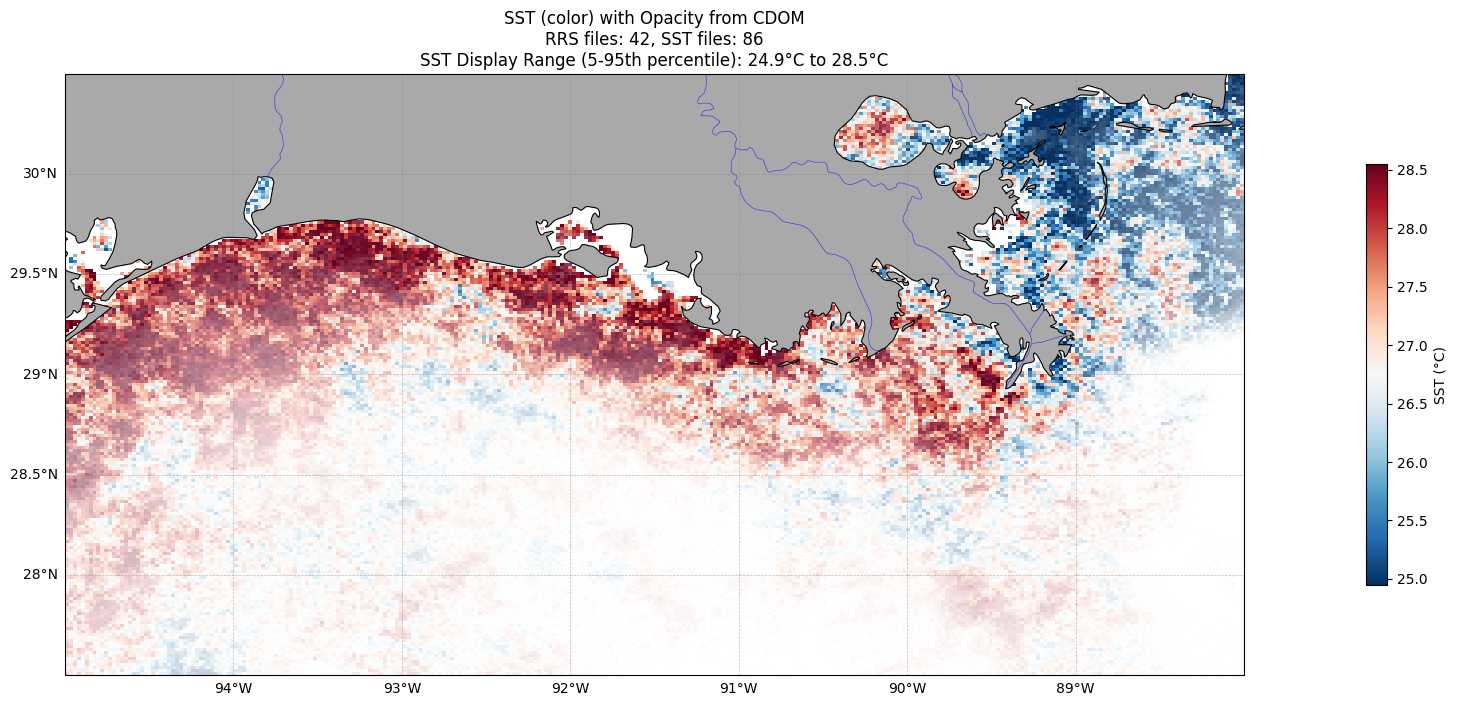

In [21]:
# --- Plotting ---
lon_span_plot = lon_edges_grid[-1] - lon_edges_grid[0]
lat_span_plot = lat_edges_grid[-1] - lat_edges_grid[0]

if lat_span_plot == 0: lat_span_plot = 1 
geo_aspect_ratio = lon_span_plot / lat_span_plot

fig_height = 7  
fig_width = fig_height * geo_aspect_ratio
fig_width = min(fig_width, 16) 
fig_width = max(fig_width, 5)

fig = plt.figure(figsize=(fig_width, fig_height))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_edges_grid[0], lon_edges_grid[-1], lat_edges_grid[0], lat_edges_grid[-1]], crs=ccrs.PlateCarree())

# --- Data for Plotting ---
sst_data_for_color = binned_sst_interpolated
# cdom_normalized is from the previous cell (ID 213b738d)
cdom_data_for_alpha = cdom_normalized 

# --- SST Colormap and Normalization ---
sst_cmap = plt.cm.get_cmap('RdBu_r').copy() # Or 'plasma', 'coolwarm', etc. <----------- color change thing
sst_cmap.set_bad(color='lightgray', alpha=0.0) # NaN SST is transparent gray

valid_sst_plot_vals = sst_data_for_color[~np.isnan(sst_data_for_color)]
vmin_sst_actual, vmax_sst_actual = None, None

if valid_sst_plot_vals.size > 0:
    vmin_sst_actual = np.percentile(valid_sst_plot_vals, 5)
    vmax_sst_actual = np.percentile(valid_sst_plot_vals, 95)
    if vmin_sst_actual >= vmax_sst_actual: # If percentiles are too close or inverted
        vmin_sst_actual = np.nanmin(valid_sst_plot_vals)
        vmax_sst_actual = np.nanmax(valid_sst_plot_vals)
    if np.isclose(vmin_sst_actual, vmax_sst_actual): # If data is completely flat or single value
        vmin_sst_actual = vmin_sst_actual - 0.5 
        vmax_sst_actual = vmax_sst_actual + 0.5
        if np.isclose(vmin_sst_actual, vmax_sst_actual): # Fallback if still too close
             vmin_sst_actual -= 0.01
             vmax_sst_actual += 0.01
else:
    print("Warning: All SST data is NaN. Using default colorbar range for SST.")
    vmin_sst_actual = 20.0 # Example default
    vmax_sst_actual = 30.0 # Example default

norm_sst_actual = matplotlib.colors.Normalize(vmin=vmin_sst_actual, vmax=vmax_sst_actual)

# --- Create RGBA image ---
# Get RGB from SST data
rgba_image = sst_cmap(norm_sst_actual(sst_data_for_color))

# Prepare alpha channel from CDOM data (0-1 range)
# Convert NaNs in CDOM to be fully transparent
alpha_channel = np.nan_to_num(cdom_data_for_alpha, nan=0.0)

# Apply CDOM-derived alpha channel.
# Where SST is NaN, alpha is already 0 from sst_cmap.set_bad(alpha=0.0).
# Where SST is not NaN, set alpha from cdom.
rgba_image[..., 3] = np.where(~np.isnan(sst_data_for_color), alpha_channel, rgba_image[..., 3])

# --- Plotting the RGBA image ---
img = ax.imshow(rgba_image, origin='lower', 
                extent=[lon_edges_grid[0], lon_edges_grid[-1], lat_edges_grid[0], lat_edges_grid[-1]],
                transform=ccrs.PlateCarree(),
                aspect='auto') # No cmap or norm needed here as it's an RGBA image

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0) 
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)
ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue', alpha=0.6, zorder=1)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Colorbar for SST
sm = matplotlib.cm.ScalarMappable(cmap=sst_cmap, norm=norm_sst_actual)
sm.set_array([]) # Necessary for ScalarMappable
cbar = fig.colorbar(sm, ax=ax, label='SST (°C)', shrink=0.7, pad=0.08, orientation='vertical')

# Updated Title
title_parts = [
    f"SST (color) with Opacity from CDOM",
    f"RRS files: {len(nc_files_rrs)}, SST files: {len(nc_files_sst)}"
]
if valid_sst_plot_vals.size > 0 and vmin_sst_actual is not None and vmax_sst_actual is not None:
    title_parts.append(f"SST Display Range (5-95th percentile): {vmin_sst_actual:.1f}°C to {vmax_sst_actual:.1f}°C")
else:
    title_parts.append("SST Data: All NaNs or no valid range")

plt.title("\n".join(title_parts), fontsize=12)
    
plt.tight_layout(pad=0.5) 
plt.show()

### (Optional) Plotting Raw Interpolated CDOM

For reference, plot the processed CDOM data.

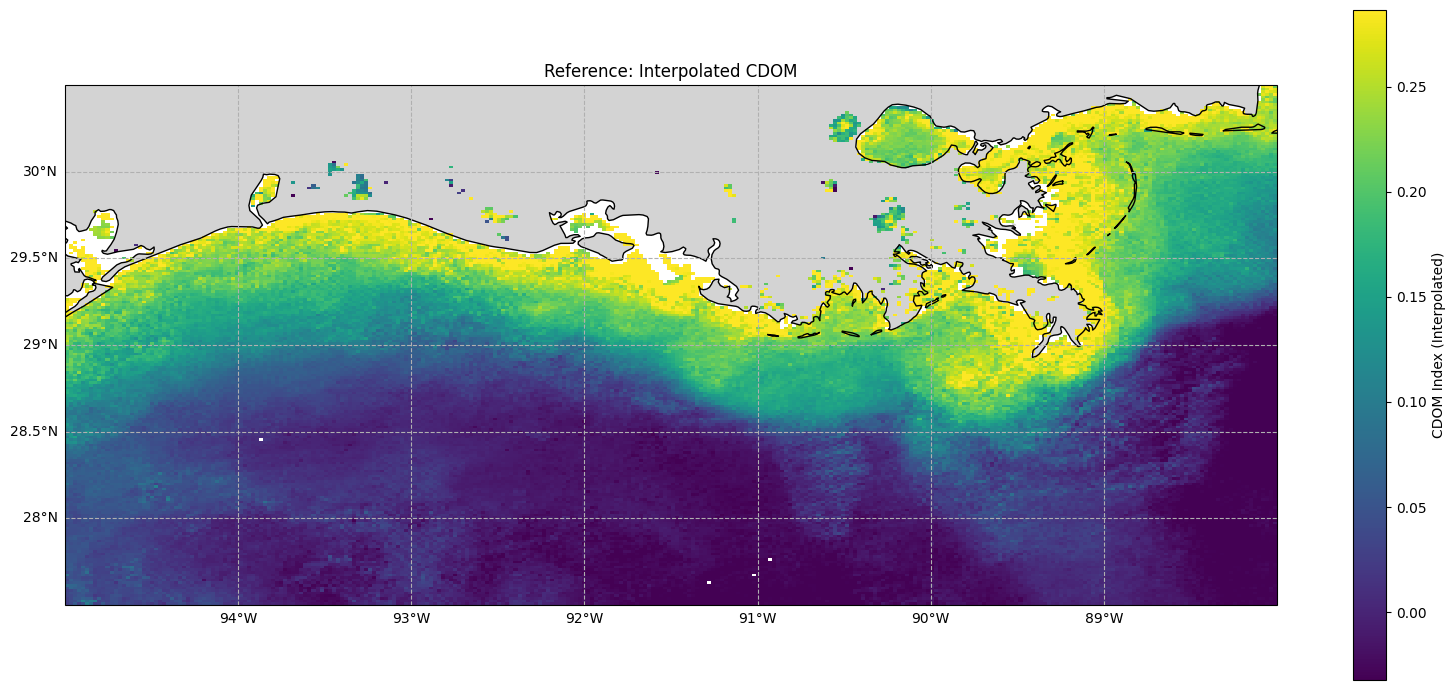

In [17]:
if 'binned_cdom_interpolated' in locals() and binned_cdom_interpolated.size > 0 and np.any(~np.isnan(binned_cdom_interpolated)) and lat_edges_grid is not None and lon_edges_grid is not None:
    fig_cdom_height = 7  
    fig_cdom_width = fig_height * geo_aspect_ratio
    fig_cdom_width = min(fig_width, 16) 
    fig_cdom_width = max(fig_width, 5)
    fig_cdom_ref = plt.figure(figsize=(fig_cdom_width, fig_cdom_height))
    ax_cdom_ref = plt.axes(projection=ccrs.PlateCarree())
    ax_cdom_ref.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    valid_cdom_plot_vals = binned_cdom_interpolated[~np.isnan(binned_cdom_interpolated)]
    vmin_cdom_plot = np.percentile(valid_cdom_plot_vals, 5) if valid_cdom_plot_vals.size > 0 else 0
    vmax_cdom_plot = np.percentile(valid_cdom_plot_vals, 95) if valid_cdom_plot_vals.size > 0 else 0.1
    if vmin_cdom_plot >= vmax_cdom_plot: vmin_cdom_plot = np.nanmin(valid_cdom_plot_vals); vmax_cdom_plot = np.nanmax(valid_cdom_plot_vals)
    if vmin_cdom_plot == vmax_cdom_plot: vmin_cdom_plot -=0.01; vmax_cdom_plot +=0.01

    raster_cdom_ref = ax_cdom_ref.pcolormesh(
        lon_edges_grid, lat_edges_grid, binned_cdom_interpolated,
        cmap='viridis', shading='auto', transform=ccrs.PlateCarree(),
        vmin=vmin_cdom_plot, vmax=vmax_cdom_plot
    )
    ax_cdom_ref.add_feature(cfeature.COASTLINE)
    ax_cdom_ref.add_feature(cfeature.LAND, facecolor='lightgray')
    gl_cdom_ref = ax_cdom_ref.gridlines(draw_labels=True, linestyle='--')
    gl_cdom_ref.top_labels = False; gl_cdom_ref.right_labels = False
    plt.colorbar(raster_cdom_ref, label='CDOM Index (Interpolated)')
    plt.title("Reference: Interpolated CDOM")
    plt.tight_layout()
    plt.show()
else:
    print("Skipping raw CDOM plot: No data or grid.")

### (Optional) Plotting Raw Interpolated SST

For reference, plot the processed SST data.

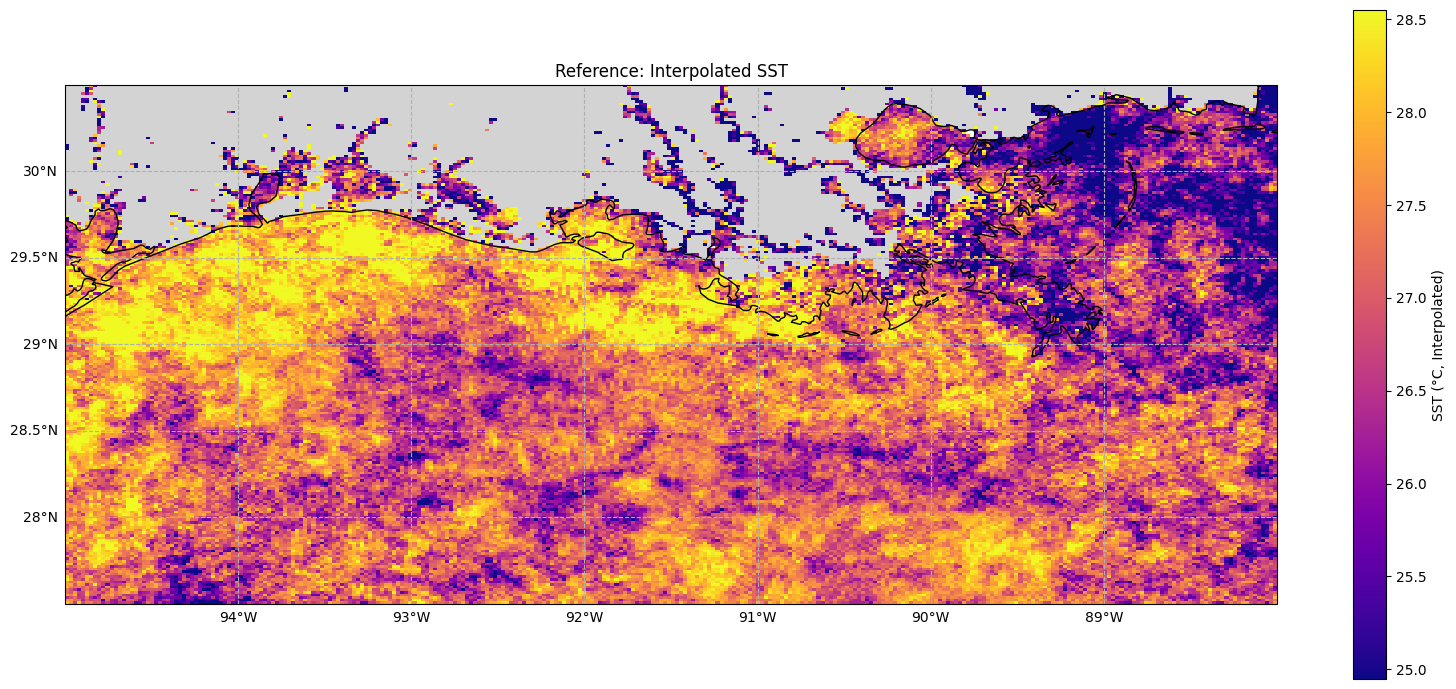

In [18]:
if 'binned_sst_interpolated' in locals() and binned_sst_interpolated.size > 0 and np.any(~np.isnan(binned_sst_interpolated)) and lat_edges_grid is not None and lon_edges_grid is not None:
    fig_sst_height = 7  
    fig_sst_width = fig_height * geo_aspect_ratio
    fig_sst_width = min(fig_width, 16) 
    fig_sst_width = max(fig_width, 5)
    fig_sst_ref = plt.figure(figsize=(fig_sst_width, fig_sst_height))
    ax_sst_ref = plt.axes(projection=ccrs.PlateCarree())
    ax_sst_ref.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    valid_sst_plot_vals = binned_sst_interpolated[~np.isnan(binned_sst_interpolated)]
    vmin_sst_plot = np.percentile(valid_sst_plot_vals, 5) if valid_sst_plot_vals.size > 0 else 10
    vmax_sst_plot = np.percentile(valid_sst_plot_vals, 95) if valid_sst_plot_vals.size > 0 else 30
    if vmin_sst_plot >= vmax_sst_plot: vmin_sst_plot = np.nanmin(valid_sst_plot_vals); vmax_sst_plot = np.nanmax(valid_sst_plot_vals)
    if vmin_sst_plot == vmax_sst_plot: vmin_sst_plot -=0.5; vmax_sst_plot +=0.5

    raster_sst_ref = ax_sst_ref.pcolormesh(
        lon_edges_grid, lat_edges_grid, binned_sst_interpolated,
        cmap='plasma', shading='auto', transform=ccrs.PlateCarree(),
        vmin=vmin_sst_plot, vmax=vmax_sst_plot
    )
    ax_sst_ref.add_feature(cfeature.COASTLINE)
    ax_sst_ref.add_feature(cfeature.LAND, facecolor='lightgray')
    gl_sst_ref = ax_sst_ref.gridlines(draw_labels=True, linestyle='--')
    gl_sst_ref.top_labels = False; gl_sst_ref.right_labels = False
    plt.colorbar(raster_sst_ref, label='SST (°C, Interpolated)')
    plt.title("Reference: Interpolated SST")
    plt.tight_layout()
    plt.show()
else:
    print("Skipping raw SST plot: No data or grid.")